In [1]:
import simi

import pandas as pd
from sentence_transformers import evaluation, losses, models, InputExample, SentenceTransformer
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, BertForMaskedLM, AutoModelForMaskedLM, AutoModel

from tqdm.auto import tqdm
tqdm.pandas()

RANDOM_STATE = 1

#set_seed(RANDOM_STATE)
#enable_full_determinism(RANDOM_STATE)


# SentenceTransformers cosine-similarity scoring for (m)class
def st_similarity_scoring(df, model, append=False, name="cos-sim"):
    scores = df.progress_apply(lambda r: simi.pairwise_cosine_similarity(simi.model_embeddings(model, [r["title_a"], r["title_b"]]))[0][0], axis=1)
    scores = pd.Series(scores, index=df.index, name=name)
    if append:
        return df.merge(scores.to_frame(), left_index=True, right_index=True)
    return scores

2024-01-14 14:56:26.220298: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load and select test data

In [2]:
df = pd.read_csv("class-zbmath-dataset.csv", index_col=0)
df.sample(5)

,title_a,MSC_a,MSC2_a,title_b,MSC_b,MSC2_b,label
174409,Finite deformation analysis of motion of granu...,74E05,"('74C15', '74C20', '74S05')",Elastodynamic Doppler effects in an anisotropi...,74J05,"('74H05', '74E10')",0
158978,An adaptive Poisson solver using hierarchical ...,65N55,"('65N30', '65F10', '35J05')",The dual reciprocity boundary integral equatio...,65N38,"('35R11',)",0
227393,On Pareto control of distributed systems with ...,49J20,"('74B05',)",Multimodal image registration by elastic match...,49J20,"('68U10', '49M37', '74B05', '74B20', '26B25')",1
409535,Asymptotic behavior of the averaged distributi...,35J45,"('47F05', '35P20')",The range of the tangential Cauchy-Riemann ope...,35J45,"('35N15', '47F05')",1
71025,Solving ordinary differential equations with d...,65L05,"('34A34',)",The error in quasi-quantum mechanical calculat...,65L05,"('81V55', '34A34')",1


In [3]:
X_treval, X_test = train_test_split(df, train_size=0.9, random_state=RANDOM_STATE)
X_train, X_eval = train_test_split(X_treval, train_size=0.888889, random_state=RANDOM_STATE)
print("train:", len(X_train), "eval:", len(X_eval), "test:", len(X_test))

train: 351472 eval: 43935 test: 43935


## Model definitions

In [4]:
# combine models into dict
eval_models = {
    'SBERT+ANCH-ARX+CLASS-ZBM': SentenceTransformer('./sbert+retrain_anchor_arxiv_class_zbmath'),
    'SBERT+CLASS-ZBM+ANCH-ARX': SentenceTransformer('./sbert+retrain_class_zbmath_anchor_arxiv'),
    'SBERT+CLASS-ARX+CLASS-ZBM+ANCH-ARX': SentenceTransformer('./sbert+retrain_class_arxiv_class_zbmath_anchor_arxiv'),
    'SBERT+ANCH-ARX+CLASS-ARX+CLASS-ZBM': SentenceTransformer('./sbert+retrain_anchor_arxiv_class_arxiv_class_zbmath'),
    'SBERT+CLASS-ARX+ANCH-ARX+CLASS-ZBM': SentenceTransformer('./sbert+retrain_class_arxiv_anchor_arxiv_class_zbmath'),
    
    'SPECTER2+ANCH-ARX+CLASS-ZBM': SentenceTransformer('./specter2+mp+retrain_anchor_arxiv_class_zbmath'),
    'SPECTER2+CLASS-ZBM+ANCH-ARX': SentenceTransformer('./specter2+mp+retrain_class_zbmath_anchor_arxiv'),
    'SPECTER2+CLASS-ARX+CLASS-ZBM+ANCH-ARX': SentenceTransformer('./specter2+mp+retrain_class_arxiv_class_zbmath_anchor_arxiv'),
    'SPECTER2+ANCH-ARX+CLASS-ARX+CLASS-ZBM': SentenceTransformer('./specter2+mp+retrain_anchor_arxiv_class_arxiv_class_zbmath'),
    'SPECTER2+CLASS-ARX+ANCH-ARX+CLASS-ZBM': SentenceTransformer('./specter2+mp+retrain_class_arxiv_anchor_arxiv_class_zbmath'),
    
    'BERT+MLM+ANCH-ARX+CLASS-ZBM': SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_anchor_arxiv_class_zbmath'),
    'BERT+MLM+CLASS-ZBM+ANCH-ARX': SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_zbmath_anchor_arxiv'),
    'BERT+MLM+CLASS-ARX+CLASS-ZBM+ANCH-ARX': SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_arxiv_class_zbmath_anchor_arxiv'),
    'BERT+MLM+ANCH-ARX+CLASS-ARX+CLASS-ZBM': SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_arxiv_anchor_class_arxiv_class_zbmath'),
    'BERT+MLM+CLASS-ARX+ANCH-ARX+CLASS-ZBM': SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_arxiv_anchor_arxiv_class_zbmath'),
}

## Spearman-Pearson-rank-coefficient for test data

In [5]:
eval_examples = X_test.reset_index(drop=True).apply(lambda r: InputExample(texts=[r["title_a"], r["title_b"]], label=r["label"]), axis=1)
evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(eval_examples, batch_size=64, show_progress_bar=True)

In [6]:
%%time
spear_rancs = {}

with tqdm(total=len(eval_models)) as pb:
    for n,m in eval_models.items():
        pb.set_postfix_str("Current model: {}".format(n))
        spear_rancs[n] = [m.evaluate(evaluator)]
        pb.update()
        
spear_ranc_df = pd.DataFrame(spear_rancs)

  0%|          | 0/15 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

CPU times: user 1h 9min 40s, sys: 5min 53s, total: 1h 15min 33s
Wall time: 19min 3s


In [7]:
pd.set_option('display.max_columns', 40)

In [8]:
spear_ranc_df

,SBERT+ANCH-ARX+CLASS-ZBM,SBERT+CLASS-ZBM+ANCH-ARX,SBERT+CLASS-ARX+CLASS-ZBM+ANCH-ARX,SBERT+ANCH-ARX+CLASS-ARX+CLASS-ZBM,SBERT+CLASS-ARX+ANCH-ARX+CLASS-ZBM,SPECTER2+ANCH-ARX+CLASS-ZBM,SPECTER2+CLASS-ZBM+ANCH-ARX,SPECTER2+CLASS-ARX+CLASS-ZBM+ANCH-ARX,SPECTER2+ANCH-ARX+CLASS-ARX+CLASS-ZBM,SPECTER2+CLASS-ARX+ANCH-ARX+CLASS-ZBM,BERT+MLM+ANCH-ARX+CLASS-ZBM,BERT+MLM+CLASS-ZBM+ANCH-ARX,BERT+MLM+CLASS-ARX+CLASS-ZBM+ANCH-ARX,BERT+MLM+ANCH-ARX+CLASS-ARX+CLASS-ZBM,BERT+MLM+CLASS-ARX+ANCH-ARX+CLASS-ZBM
0,0.604743,0.602917,0.600747,0.599305,0.598948,0.613647,0.614202,0.603338,0.606106,0.603821,0.605702,0.605974,0.606475,0.603956,0.605813


In [9]:
X_test_score = X_test.copy()

In [10]:
%%time
with tqdm(total=len(eval_models)) as pb:
    for n,m in eval_models.items():
        pb.set_postfix_str("Current model: {}".format(n))
        X_test_score["cos-sim ({})".format(n)] = st_similarity_scoring(X_test, m)
        pb.update()

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

CPU times: user 2h 10min 12s, sys: 3min 34s, total: 2h 13min 47s
Wall time: 1h 27min 59s


## Results for test data

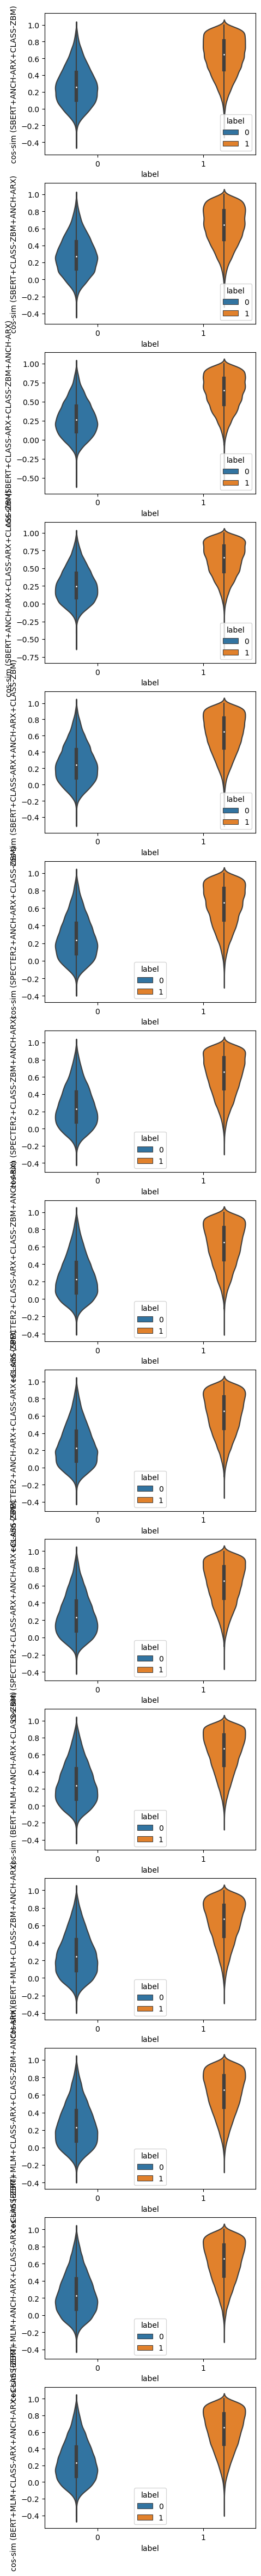

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
if len(eval_models) > 1:
    f, axs = plt.subplots(len(eval_models), 1, figsize=(5, 4*len(eval_models)))
    for i,n in enumerate(eval_models.keys()):
        sns.violinplot(X_test_score, x="label", y="cos-sim ({})".format(n), hue="label", ax=axs[i], scale="count", scale_hue=True)
else:
    for n in eval_models.keys():
        sns.violinplot(X_test_score, x="label", y="cos-sim ({})".format(n), hue="label", scale="count", scale_hue=True)

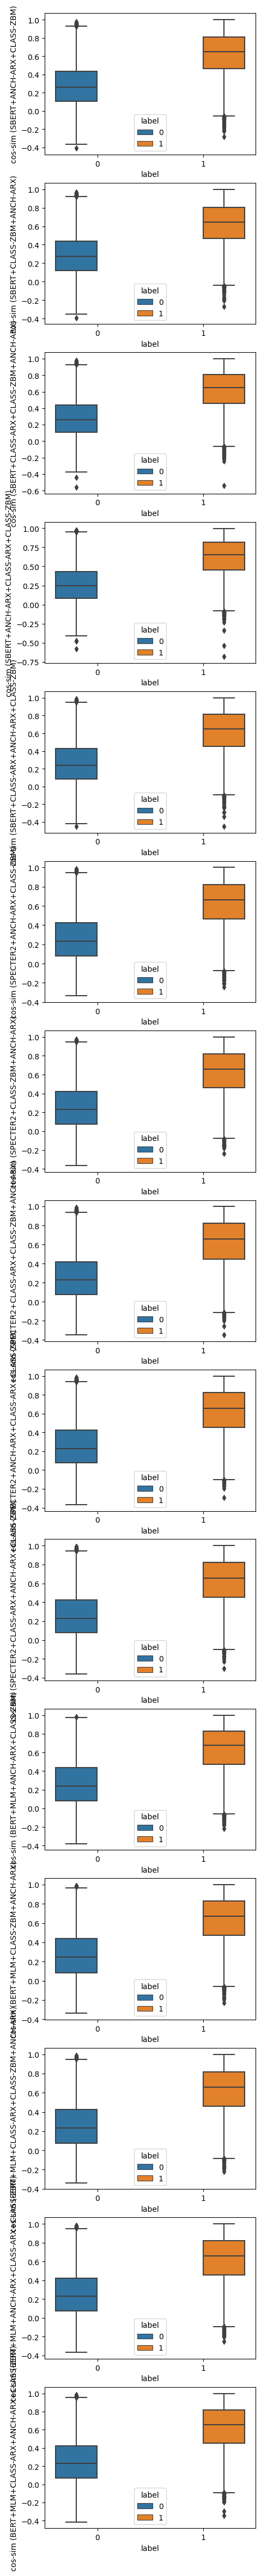

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axs = plt.subplots(len(eval_models), 1, figsize=(5, 4*len(eval_models)))
for i,n in enumerate(eval_models.keys()):
    sns.boxplot(X_test_score, x="label", y="cos-sim ({})".format(n), hue="label", ax=axs[i])

In [13]:
X_test_score[X_test_score["label"] == 1].describe()

,label,cos-sim (SBERT+ANCH-ARX+CLASS-ZBM),cos-sim (SBERT+CLASS-ZBM+ANCH-ARX),cos-sim (SBERT+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (SBERT+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (SBERT+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (SPECTER2+ANCH-ARX+CLASS-ZBM),cos-sim (SPECTER2+CLASS-ZBM+ANCH-ARX),cos-sim (SPECTER2+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (SPECTER2+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (SPECTER2+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (BERT+MLM+ANCH-ARX+CLASS-ZBM),cos-sim (BERT+MLM+CLASS-ZBM+ANCH-ARX),cos-sim (BERT+MLM+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (BERT+MLM+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (BERT+MLM+CLASS-ARX+ANCH-ARX+CLASS-ZBM)
count,21860.0,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000
mean,1.0,0.621914,0.621847,0.620903,0.620240,0.618177,0.628371,0.625357,0.621610,0.621707,0.622367,0.634347,0.634690,0.622765,0.621408,0.621426
std,0.0,0.227816,0.222886,0.227948,0.236571,0.237638,0.234504,0.236011,0.241638,0.238478,0.239016,0.236291,0.236690,0.237942,0.239590,0.239152
min,1.0,-0.284564,-0.265597,-0.540624,-0.685070,-0.448609,-0.245384,-0.237825,-0.348530,-0.290875,-0.304302,-0.217479,-0.227565,-0.220626,-0.251346,-0.343157
25%,1.0,0.462984,0.465931,0.459654,0.455182,0.451706,0.463214,0.460494,0.449425,0.452617,0.451240,0.472472,0.474098,0.457967,0.454723,0.455070
50%,1.0,0.646436,0.643615,0.648601,0.652751,0.647733,0.660939,0.659611,0.655308,0.654074,0.656389,0.674839,0.673893,0.657377,0.657816,0.657152
75%,1.0,0.809587,0.805725,0.808515,0.815328,0.815895,0.823139,0.821063,0.824656,0.821283,0.821121,0.829122,0.830283,0.819255,0.819603,0.819266
max,1.0,0.999600,0.999754,0.999530,0.999572,0.999369,0.999667,0.999749,0.998147,0.998833,0.998983,0.999315,0.998772,0.999750,0.999638,0.999688


In [14]:
X_test_score[X_test_score["label"] == 0].describe()

,label,cos-sim (SBERT+ANCH-ARX+CLASS-ZBM),cos-sim (SBERT+CLASS-ZBM+ANCH-ARX),cos-sim (SBERT+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (SBERT+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (SBERT+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (SPECTER2+ANCH-ARX+CLASS-ZBM),cos-sim (SPECTER2+CLASS-ZBM+ANCH-ARX),cos-sim (SPECTER2+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (SPECTER2+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (SPECTER2+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (BERT+MLM+ANCH-ARX+CLASS-ZBM),cos-sim (BERT+MLM+CLASS-ZBM+ANCH-ARX),cos-sim (BERT+MLM+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (BERT+MLM+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (BERT+MLM+CLASS-ARX+ANCH-ARX+CLASS-ZBM)
count,22075.0,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000
mean,0.0,0.277201,0.288277,0.281167,0.266829,0.264323,0.263527,0.258623,0.259393,0.261374,0.263115,0.270450,0.271229,0.259493,0.258264,0.257035
std,0.0,0.230433,0.223221,0.228282,0.239527,0.239051,0.238393,0.238571,0.240261,0.237682,0.238613,0.243780,0.242794,0.241799,0.243630,0.243592
min,0.0,-0.408459,-0.389195,-0.559844,-0.580956,-0.447968,-0.335562,-0.363554,-0.347957,-0.366742,-0.360894,-0.378929,-0.336990,-0.337150,-0.367286,-0.412437
25%,0.0,0.103139,0.120399,0.108919,0.085287,0.082128,0.077852,0.074282,0.073160,0.076692,0.077398,0.079785,0.080930,0.071630,0.070689,0.067251
50%,0.0,0.260226,0.272857,0.261605,0.246203,0.240156,0.235318,0.229409,0.227473,0.228554,0.230721,0.239012,0.245086,0.230480,0.228517,0.228921
75%,0.0,0.433152,0.441059,0.438085,0.432067,0.429240,0.425435,0.422504,0.418490,0.422008,0.424625,0.438289,0.436784,0.423289,0.422799,0.422701
max,0.0,0.976109,0.969519,0.982753,0.973782,0.985867,0.982598,0.977149,0.990074,0.984628,0.987865,0.978086,0.991073,0.985115,0.982672,0.986288


In [15]:
# Die Ergebnisse sehen schon sehr verdächtig aus, müssen wir ggf. Layer freezen? s. https://towardsdatascience.com/what-exactly-happens-when-we-fine-tune-bert-f5dc32885d76
X_test_score.sample(15, random_state=RANDOM_STATE)

,title_a,MSC_a,MSC2_a,title_b,MSC_b,MSC2_b,label,cos-sim (SBERT+ANCH-ARX+CLASS-ZBM),cos-sim (SBERT+CLASS-ZBM+ANCH-ARX),cos-sim (SBERT+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (SBERT+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (SBERT+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (SPECTER2+ANCH-ARX+CLASS-ZBM),cos-sim (SPECTER2+CLASS-ZBM+ANCH-ARX),cos-sim (SPECTER2+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (SPECTER2+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (SPECTER2+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (BERT+MLM+ANCH-ARX+CLASS-ZBM),cos-sim (BERT+MLM+CLASS-ZBM+ANCH-ARX),cos-sim (BERT+MLM+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (BERT+MLM+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (BERT+MLM+CLASS-ARX+ANCH-ARX+CLASS-ZBM)
15960,Global exact quadratization of continuous-time...,93C10,"('93C15', '93A10', '34H05', '34H99', '34A34', ...",Mixed \(\mathcal{H}_2/\mathcal{H}_\infty\) con...,93E03,"('60J75', '93B36', '93C55', '93C05')",0,0.021773,0.074043,0.175884,0.054413,0.165874,-0.001825,-0.088981,-0.048357,-0.020879,0.014086,0.233157,0.079194,0.267090,0.117740,0.088035
186573,Edge operators with conditions of Toeplitz type,58J40,"('35S15', '47G30', '35A17', '35J70', '58J32')",A Bismut type theorem for subelliptic heat sem...,58J20,"('35H20', '47D06')",0,0.142978,0.133102,0.389935,0.190326,0.142603,0.133035,0.334702,0.157655,0.152449,0.204298,0.355584,0.070006,0.135324,0.161510,0.234640
181977,1-cohomology and splitting of group extensions,20E22,"('20J99', '20E07')",On some products of nilpotent groups,20E22,"('20F16', '20F18', '20E07', '20F14', '20H25')",1,0.221033,0.249263,0.236188,0.477347,0.481843,0.428442,0.364642,0.224716,0.453028,0.276189,0.192569,0.235667,0.282515,0.311511,0.271451
299961,Reputation in the long-run with imperfect moni...,91A20,"('91A05',)",Parallel repetition via fortification: analyti...,91A20,"('81P40', '81P45', '91A05', '91A06', '91A12', ...",1,0.380617,0.253951,0.197685,0.340204,0.163243,0.343525,0.093589,0.127973,0.428249,0.255492,0.629702,0.496733,0.612642,0.720699,0.689296
226982,Traces and quasi-traces on the Boutet de Monve...,58J42,"('35S15',)",The local and global parts of the basic zeta c...,58J42,"('35S15',)",1,0.379822,0.283577,0.314070,0.203174,0.180775,0.199944,0.308427,0.213018,0.227127,0.201307,0.595648,0.620650,0.654859,0.657273,0.567867
306772,A cyclic weight algorithm of decoding the \((4...,94B35,"('94B40',)",A result on the weight distributions of binary...,94B35,"('94B40',)",1,0.884205,0.842817,0.885462,0.868704,0.871147,0.906434,0.903279,0.883305,0.898510,0.847562,0.799135,0.913103,0.844969,0.820687,0.890841
205892,Properties of the Székely-Móri symmetry criter...,60E05,"('62E20', '62H10')",On deformation technique of the hyperbolic sec...,60E05,"('60E10', '62E17', '62E20')",1,0.751957,0.735620,0.673509,0.763423,0.710685,0.775559,0.763608,0.749925,0.654093,0.608599,0.540706,0.555151,0.732596,0.673628,0.740418
218358,Simultaneous visibility representations of pla...,05C62,"('05C10', '05C85', '68R10')",On the minimum order of graphs with given semi...,05C99,"('05C65', '20M30')",0,0.167807,0.203494,0.228485,0.328278,0.160769,0.229635,0.311513,0.156899,0.179119,0.195873,0.363045,0.286089,0.245922,0.307556,0.196406
77078,The unsteady MHD boundary-layer flow on a shri...,76W05,"('76N20', '76M45')",Meridional trapping and zonal propagation of i...,76U05,"('76B55', '86A05')",0,0.249039,0.190636,0.122671,0.215262,0.193744,-0.004581,0.047006,0.046894,0.115381,0.044754,0.292366,0.189498,0.072177,0.127706,0.095913
63150,On unified contact metric manifold,53C15,"('53C25',)",Two characterizations of the Chern connection,53C10,"('53A55', '53B05', '58A20', '58A32')",0,0.160334,0.092319,0.318134,0.203442,0.323868,0.498573,0.539639,0.472641,0.470298,0.513748,0.431710,0.424751,0.362017,0.390787,0.389710
